# Calibration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import metric_utils
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import data_utils
from neuroprobnum.utils import stim_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython

compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
nknots = 21

# Calibrate solver
Calibrate solver on one default set of parameters

In [6]:
# Select a solver that is used for all simulations except for the reference
method = 'EE'
adaptive = False
step_param = 0.1
pert_method = 'abdulle_ln'

## Generator

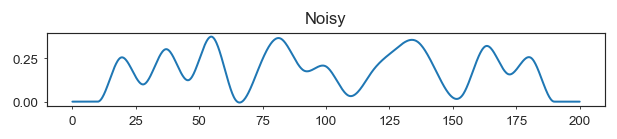

In [7]:
# Default parameters
gK_default = 36.
gN_default = 120.
gL_default = 0.3
Iamp_default = 0.2

# Default neuron
def_neuron = HHNeuron(gK=gK_default, gN=gN_default, gL=gL_default)

# Default stimulus
def_stim = stim_utils.IStimNoisy(Iamp=Iamp_default, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=nknots, seed=46)
def_stim.plot(t0=t0, tmax=tmax)

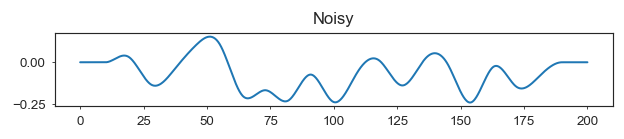

In [8]:
# Test
rnd_stim = stim_utils.IStimNoisy(Iamp=-Iamp_default/4, Irng=Iamp_default, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=nknots, seed=3).plot(t0, tmax)

In [9]:
data_base_folder = 'data_vary_parameters'

In [10]:
from neuroprobnum.generator.dataloader import DataLoader
from neuroprobnum.generator.generator_hh import DataGeneratorHH

cal_gen = DataGeneratorHH(
    return_vars=['ys'],
    y0=def_neuron.compute_yinf(-65), t0=t0, tmax=tmax,
    model=def_neuron, n_samples=100, n_parallel=20,
    gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
    base_folder=data_base_folder,
)
cal_gen.load_acc_sols_from_file()
cal_dl = DataLoader(cal_gen)

Not acc sols file found!


## Examples

Generate some examples that show how the parameter influence the model output

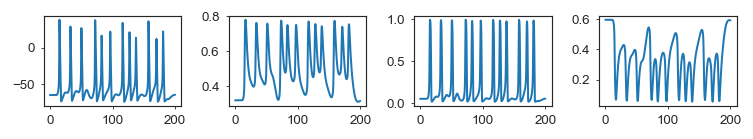

In [11]:
cal_gen.model.get_Istim_at_t = def_stim.get_I_at_t
cal_gen.model.set_gs(gK=gK_default, gN=gN_default, gL=gL_default)
cal_gen.gen_sol(method=method, adaptive=adaptive, step_param=step_param, pert_method=None, n_samples=1).plot()

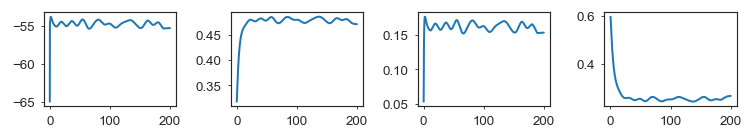

In [12]:
cal_gen.model.get_Istim_at_t = def_stim.get_I_at_t
cal_gen.model.set_gs(gK=gK_default, gN=gN_default, gL=gL_default*100)
cal_gen.gen_sol(method=method, adaptive=adaptive, step_param=step_param, pert_method=None, n_samples=1).plot()

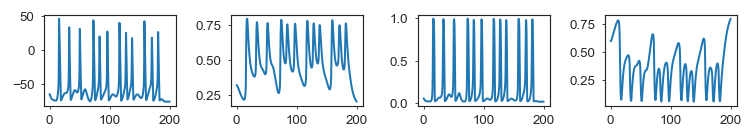

In [13]:
cal_gen.model.get_Istim_at_t = def_stim.get_I_at_t
cal_gen.model.set_gs(gK=gK_default, gN=gN_default, gL=gL_default/100.)
cal_gen.gen_sol(method=method, adaptive=adaptive, step_param=step_param, pert_method=None, n_samples=1).plot()

## Calibrate model

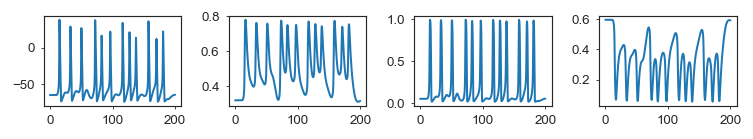

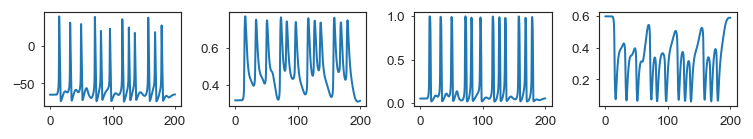

In [14]:
# Reset the neuron to the default parameters
cal_gen.model.get_Istim_at_t = def_stim.get_I_at_t
cal_gen.model.set_gs(gK=gK_default, gN=gN_default, gL=gL_default)

# Create and plot solutions
def_det_sol = cal_gen.gen_det_sol(method=method, adaptive=adaptive, step_param=step_param)
def_acc_sol = cal_gen.gen_acc_sol(t_eval=def_det_sol.get_ts())

def_det_sol.plot()
def_acc_sol.plot()

In [15]:
def eval_pp_MAERP_SM_DR_c(pert_param, verbose=False, plot=False, seed=42):
    """Evaluate the calibration score measured as MAERP_SM_DR_c"""
    sol = cal_gen.gen_sol(method=method, adaptive=adaptive, step_param=step_param, pert_method=pert_method, pert_param=pert_param, seed=seed)

    MAE_SM, MAE_SR, MAE_DR = cal_dl.compute_maes(samples=sol.get_ys(yidx=cal_gen.vidx), target=def_acc_sol.get_ys(yidx=cal_gen.vidx), det=def_det_sol.get_ys(yidx=cal_gen.vidx))
    
    MAE_SR_avg = np.mean(MAE_SR)
    MAE_SM_avg = np.mean(MAE_SM)
    MAER_SM_SR = MAE_SM_avg / MAE_SR_avg
    MAER_DR_SR = MAE_DR / MAE_SR_avg
    MAERP_SM_DR_c = metric_utils.compute_MAERP_SM_DR_c(MAER_SM_SR, MAER_DR_SR)
    
    if plot:
        sol.plot()
    
    if verbose:
        print(f'pert_param={pert_param:.2g} -> {MAERP_SM_DR_c:.4f}')
    
    return MAE_SR_avg, MAE_SM_avg, MAER_SM_SR, MAER_DR_SR, MAERP_SM_DR_c

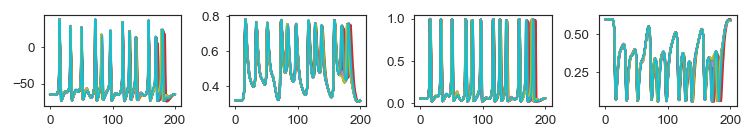

pert_param=1 -> 0.3783


In [16]:
eval_pp_MAERP_SM_DR_c(pert_param=1., verbose=True, plot=True);

In [17]:
def get_pert_params(explb, expub, expstep):
    """Get pert params for given exponents"""
    pert_params = 2.** np.append(np.around(np.arange(explb, expub, float(expstep)), 5), expub)
    return pert_params

In [18]:
overwrite = False

df_cal_file = os.path.join(cal_gen.base_folder, 'df_cal.pkl')

if os.path.isfile(df_cal_file) and not overwrite:
    print("Load data")
    df_cal = data_utils.load_var(os.path.join(cal_gen.base_folder, 'df_cal.pkl'))
    
else:
    print("Create data")
    # Compute calibration scores for different perturbation parameters
    cal_pert_params = get_pert_params(-4, 4, 0.5)

    np.random.seed(43513215)
    seeds = np.random.randint(0, np.iinfo(np.int32).max, cal_pert_params.size, dtype=np.int32)

    df_cal = pd.DataFrame()

    for i, cal_pert_param in enumerate(cal_pert_params):
        seed = seeds[i]
        MAE_SR_avg, MAE_SM_avg, MAER_SM_SR, MAER_DR_SR, MAERP_SM_DR_c = \
            eval_pp_MAERP_SM_DR_c(pert_param=cal_pert_param, verbose=True, plot=False, seed=seed);

        df_cal = df_cal.append({
            'seed': seed,
            'n_samples': cal_gen.n_samples,
            'pert_param': cal_pert_param,
            'MAE_SR_avg': MAE_SR_avg,
            'MAE_SM_avg': MAE_SM_avg,
            'MAER_SM_SR': MAER_SM_SR,
            'MAER_DR_SR': MAER_DR_SR,
            'MAERP_SM_DR_c': MAERP_SM_DR_c,
        }, ignore_index=True)

    # Save data
    data_utils.make_dir(cal_gen.base_folder)
    data_utils.save_var(df_cal, df_cal_file)

Load data


In [19]:
df_cal = df_cal.reset_index().set_index('pert_param')
df_cal.head()

,index,MAERP_SM_DR_c,MAER_DR_SR,MAER_SM_SR,MAE_SM_avg,MAE_SR_avg,n_samples,seed
pert_param,,,,,,,,
0.062500,0,0.025082,0.998799,0.025112,0.216429,8.618482,100.0,6.586334e+08
0.088388,1,0.035861,0.999400,0.035883,0.309071,8.613299,100.0,2.025419e+09
0.125000,2,0.051635,0.999585,0.051656,0.444850,8.611706,100.0,1.973741e+09
0.176777,3,0.074600,1.000760,0.074600,0.641681,8.601594,100.0,3.423061e+08
0.250000,4,0.100850,0.993634,0.101496,0.879287,8.663283,100.0,1.502863e+09


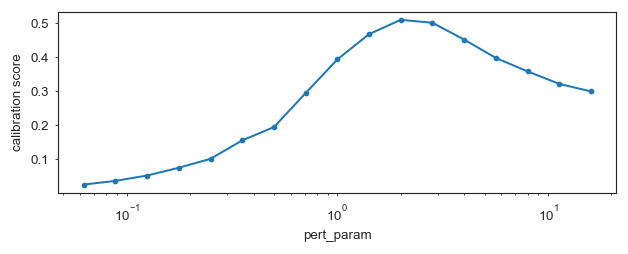

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(df_cal.index, df_cal['MAERP_SM_DR_c'], '.-')
ax.set(xlabel='pert_param', ylabel='calibration score', xscale='log')
plt.show()

In [21]:
# Pick perturbation parameter that is used in all following experiments
best_pert_param = df_cal.reset_index().loc[df_cal.MAERP_SM_DR_c.argmax()].pert_param
best_pert_param

2.0

## Generate data

In [22]:
rnd_neuron = HHNeuron(gK=0, gN=0, gL=0)

gen = DataGeneratorHH(
    return_vars=['ys', 'events'],
    y0=rnd_neuron.compute_yinf(-65), t0=t0, tmax=tmax,
    acc_step_param=1e-6, acc_min_step=1e-4,
    model=rnd_neuron, n_samples=100, n_parallel=20,
    gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
    base_folder=data_base_folder,
)
gen.load_acc_sols_from_file()
dl = DataLoader(gen)

Not acc sols file found!


In [23]:
def eval_params(gK, gN, gL, Iamp, verbose=False, plot=False, seed=42):
    """Evalualte model for different HH model parameter sets"""
    rnd_neuron.set_gs(gK=gK, gN=gN, gL=gL)
    rnd_stim = stim_utils.IStimNoisy(Iamp=Iamp, Irng=Iamp_default, onset=stim_onset, offset=stim_offset, name='Noisy', nknots=nknots, seed=int(seed/2))
    rnd_neuron.get_Istim_at_t = rnd_stim.get_I_at_t
    
    gen.y0 = rnd_neuron.get_y0()
    
    det_sol = gen.gen_det_sol(method='EE', adaptive=0, step_param=step_param)
    sol = gen.gen_sol(method='EE', adaptive=0, step_param=step_param, pert_method='abdulle_ln', pert_param=best_pert_param, seed=seed)
    acc_sol = gen.gen_acc_sol(t_eval=sol.get_ts())
    
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
        ax.plot(sol.get_ts(), sol.get_ys(yidx=gen.vidx).T, alpha=0.5, c='k')
        ax.plot(det_sol.get_ts(), det_sol.get_ys(yidx=gen.vidx), c='c', label='det')
        ax.plot(acc_sol.get_ts(), acc_sol.get_ys(yidx=gen.vidx), c='red', label='acc', ls='--')
        ax.legend()
        plt.show()
    
    return sol, det_sol, acc_sol

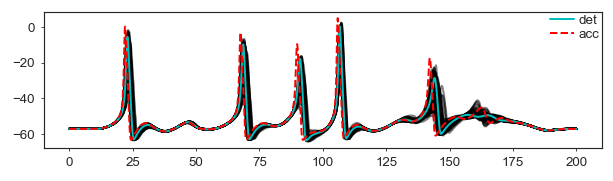

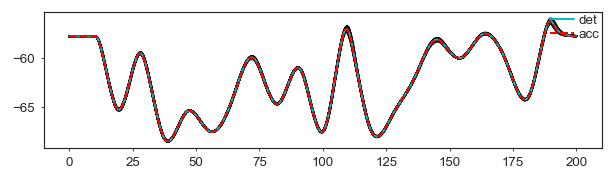

In [24]:
# Example
eval_params(gK=20, gN=100, gL=3, Iamp=0.2, verbose=False, plot=True, seed=42);
eval_params(gK=20, gN=50, gL=3, Iamp=-0.2, verbose=False, plot=True, seed=42);

In [25]:
def sample_g(mean, std):
    msquared = mean**2
    phi = np.sqrt(std**2 + msquared)
    loc = np.log(msquared / phi)
    scale = np.sqrt(np.log(phi ** 2 / msquared))
    return np.exp(np.random.normal(loc=loc, scale=scale))


def sample_params():
    gK = sample_g(36., 36./2)
    gN = sample_g(120., 120./2)
    gL = sample_g(0.3, 0.3/2)
    Iamp = np.random.normal(0.2, 0.2)
    return gK, gN, gL, Iamp


np.random.seed(42)
n_psets = 100
parameter_sets = [sample_params() for i in range(n_psets*2)] # Create some more in case some fail
seeds = np.random.randint(0, np.iinfo(np.int32).max, len(parameter_sets), dtype=np.int32)

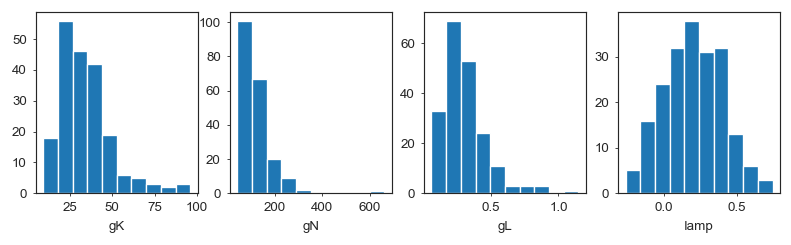

In [26]:
ps = np.array(parameter_sets)
fig, axs = plt.subplots(1, ps.shape[1], figsize=(8, 2))

for ax, psi in zip(axs, ps.T):
    ax.hist(psi)
    
axs[0].set(xlabel="gK")
axs[1].set(xlabel="gN")
axs[2].set(xlabel="gL")
axs[3].set(xlabel="Iamp")
plt.show()

In [27]:
overwrite = False

evals_file = os.path.join(gen.base_folder, 'evals.pkl')

if os.path.isfile(evals_file) and not overwrite:
    print("Load data")
    evals = data_utils.load_var(evals_file)
    assert evals['pert_param'] == best_pert_param
else:
    evals = dict(parameter_sets=[], sols=[], det_sols=[], acc_sols=[], pert_param=best_pert_param)

    from tqdm.notebook import tqdm
    for i, (gK, gN, gL, Iamp) in tqdm(enumerate(parameter_sets), total=n_psets):
        try:
            sol, det_sol, acc_sol = eval_params(gK, gN, gL, Iamp, verbose=False, plot=i<10, seed=seeds[i])
            evals['parameter_sets'].append((gK, gN, gL, Iamp))
            evals['sols'].append(sol)
            evals['acc_sols'].append(acc_sol)
            evals['det_sols'].append(det_sol)
        except ValueError:
            pass

        if len(evals["sols"]) == n_psets:
            break
            
    data_utils.make_dir(gen.base_folder)
    data_utils.save_var(evals, evals_file)

Load data


#### Load to DataFrame

In [28]:
df = pd.DataFrame(columns=['n_samples', 'gK', 'gN', 'gL', 'Iamp', 'vs', 'det_vs', 'acc_vs', 'events', 'det_events', 'acc_events'])

for parameter_set, sol, det_sol, acc_sol in zip(evals["parameter_sets"], evals["sols"], evals["det_sols"], evals["acc_sols"]):
    gK, gN, gL, Iamp = parameter_set
    
    vs=sol.get_ys(yidx=gen.vidx)
    det_vs=det_sol.get_ys(yidx=gen.vidx)
    acc_vs=acc_sol.get_ys(yidx=gen.vidx)
    
    MAE_SM, MAE_SR, MAE_DR = dl.compute_maes(samples=vs, target=acc_vs, det=det_vs)
    
    data = dict(
        n_samples=vs.shape[0],
        gK=gK, gN=gN, gL=gL, Iamp=Iamp, vs=vs, det_vs=det_vs, acc_vs=acc_vs,
        events=sol.events,
        det_events=det_sol.events,
        acc_events=acc_sol.events,
        MAE_SM=MAE_SM, MAE_SR=MAE_SR, MAE_DR=MAE_DR,
    )
    
    df = df.append(data, ignore_index=True)

In [29]:
import utils

utils.add_SR_SM(df)
df.head()

,n_samples,gK,gN,gL,Iamp,vs,det_vs,acc_vs,events,det_events,acc_events,MAE_DR,MAE_SM,MAE_SR,MAE_SR_avg,MAE_SM_avg,MAER_SM_SR,MAER_DR_SR,MAERP_SM_DR,MAERP_SM_DR_c
0,100,40.714543,100.545119,0.364369,0.504606,"[[-65.06348665327587, -65.06348706966807, -65....","[-65.06348665327587, -65.06348723160477, -65.0...","[-65.06348665327587, -65.06348723274121, -65.0...","[[[14.848246454521348]], [[14.475130919347396]...",[[14.512550272077512]],"[[14.144875224133186, 23.462348050695166]]",7.755248,"[4.803508987839101, 3.839706346286918, 5.92221...","[9.181995601295279, 7.54060315570851, 7.960340...",8.513321,5.159121,0.606006,0.910954,0.552044,0.552044
1,100,28.827726,96.093164,0.565777,0.353487,"[[-62.63743252437199, -62.63743255623892, -62....","[-62.63743252437199, -62.63743256992518, -62.6...","[-62.63743252437199, -62.63743257007534, -62.6...","[[[15.408488204370714, 24.812281902632268, 45....","[[15.398129620085873, 25.320502856824344, 46.1...","[[14.951633252723596, 24.237951143550376, 33.6...",13.291814,"[9.184017166357997, 7.283883635594361, 6.17268...","[15.113078603996257, 15.077409466800853, 14.93...",14.792350,8.494052,0.574219,0.898560,0.515970,0.515970
2,100,25.794893,138.686345,0.215573,0.106854,"[[-64.24639594371206, -64.2463978074395, -64.2...","[-64.24639594371206, -64.24639827457499, -64.2...","[-64.24639594371206, -64.24639828277614, -64.2...","[[[15.647376184018302, 27.06589795604425, 37.4...","[[15.461483388028812, 26.584318698497164, 36.9...","[[15.016177076744341, 25.57452298218324, 35.43...",18.091201,"[7.550447613416183, 8.904849645928314, 11.1194...","[20.070805569971252, 21.65751408758424, 20.142...",17.918903,9.546023,0.532735,1.009615,0.537857,0.532735
3,100,36.098289,43.472270,0.118794,0.087542,"[[-68.00874757421133, -68.00874642226121, -68....","[-68.00874757421133, -68.00874692130682, -68.0...","[-68.00874757421133, -68.0087469210708, -68.00...","[[[23.766410822441994, 51.789425753278955, 70....","[[23.69889670979897, 51.86512549795214, 71.036...","[[23.28246336557904, 51.606317532775, 70.66843...",1.758211,"[1.6411628723787035, 1.3401973890337349, 1.589...","[2.451698845271453, 3.068623452920565, 2.61641...",2.628071,1.584523,0.602922,0.669012,0.403362,0.403362
4,100,19.955509,124.507300,0.174736,-0.082461,"[[-63.712548386511166, -63.71254141722294, -63...","[-63.712548386511166, -63.71254254934638, -63....","[-63.712548386511166, -63.71254252843876, -63....","[[[34.48664104711701, 58.468953863515736, 92.0...","[[34.322233289088366, 59.52191287428471, 92.36...","[[34.041926777777306, 59.166958100512154, 92.0...",6.043443,"[5.0889929178992315, 5.034746133266169, 5.6495...","[5.823414099208349, 4.573916734266347, 6.68813...",6.674338,5.050533,0.756709,0.905475,0.685181,0.685181


In [30]:
df['acc_n_spikes'] = df.acc_events.apply(lambda x: len(x[gen.vidx]))
df['det_n_spikes'] = df.acc_events.apply(lambda x: len(x[gen.vidx]))
df['n_spikes'] = df.events.apply(lambda x: np.array([len(xi[gen.vidx]) for xi in x]))

# Plot

### Reference solutions

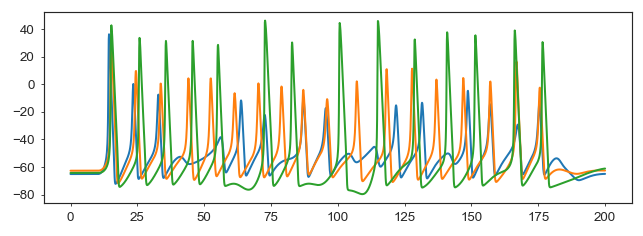

In [31]:
acc_vs = np.array([acc_sol.get_ys(yidx=gen.vidx) for acc_sol in evals['acc_sols']])
plt.plot(def_acc_sol.get_ts(), acc_vs[:3].T);

# Figure

In [32]:
cal_color = 'C3'
theta_color = 'C0'
theta_bins = 15

In [33]:
logfun = np.log2

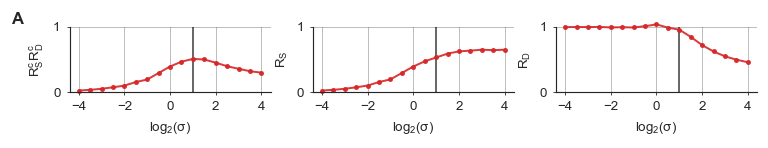

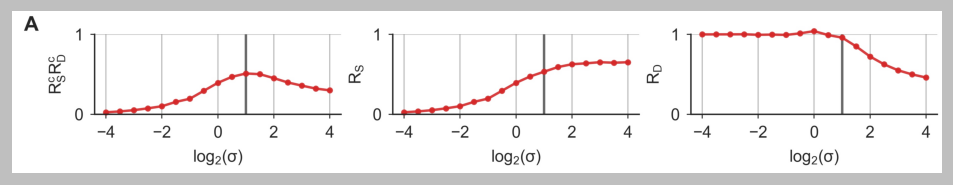

In [34]:
def plot_cal_R(ax, x):
    ax.plot(logfun(df_cal.index), df_cal[x], '.-', c=cal_color, clip_on=False, ms=4, alpha=0.9)
    ax.axvline(logfun(best_pert_param), c='dimgray', zorder=-10)

    ax.set_ylabel(pltu.text2mathtext(pltu.metric2label(x)))
    if logfun == np.log10:
        ax.set_xlabel(pltu.text2mathtext("log_10 " + f"({pltu.pert_param_symbol})"))
    elif logfun == np.log2:
        ax.set_xlabel(pltu.text2mathtext("log_2 " + f"({pltu.pert_param_symbol})"))
    else:
        ax.set_xlabel(str(logfun))
    
fig, axs = pltu.subplots(3, 1, ysize=1.1)
sns.despine()

ax = axs[0]
plot_cal_R(ax=ax, x='MAERP_SM_DR_c')

ax = axs[1]
plot_cal_R(ax=ax, x='MAER_SM_SR')

ax = axs[2]
plot_cal_R(ax=ax, x='MAER_DR_SR')

for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])
    pltu.grid(ax)

pltu.set_labs(panel_nums=['A'], axs=axs[0], panel_num_space=10)
plt.tight_layout(pad=0.3, rect=[0.03, 0, 1, 1 ])
pltu.savefig("figS4_a")
plt.show()
pltu.show_saved_figure(fig)

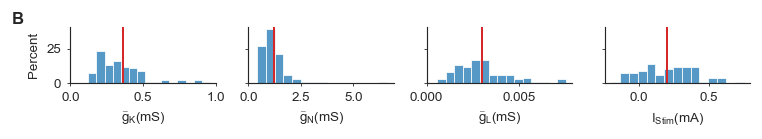

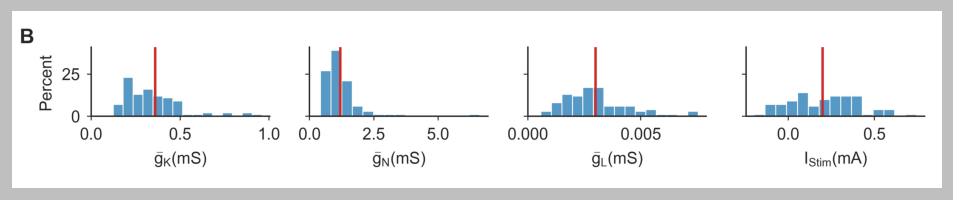

In [35]:
def plot_theta_i(ax, data, label):
    sns.histplot(ax=ax, data=data, bins=theta_bins, stat='percent', color=theta_color)
    ax.set_xlabel(label)

fig, axs = pltu.subplots(ps.shape[1], 1, sharey=True)
sns.despine()
  
ax = axs[0]
plot_theta_i(ax=ax, data=df['gK']/100, label=pltu.text2mathtext(r"\bar{g}_K (mS)"))
ax.axvline(gK_default/100, c=cal_color)
    
ax = axs[1]
plot_theta_i(ax=ax, data=df['gN']/100, label=pltu.text2mathtext(r"\bar{g}_N (mS)"))
ax.axvline(gN_default/100, c=cal_color)
    
ax = axs[2]
plot_theta_i(ax=ax, data=df['gL']/100, label=pltu.text2mathtext(r"\bar{g}_L (mS)"))
ax.axvline(gL_default/100, c=cal_color)

ax = axs[3]
plot_theta_i(ax=ax, data=df['Iamp'], label=pltu.text2mathtext("I_Stim (mA)"))
ax.axvline(Iamp_default, c=cal_color)

pltu.set_labs(panel_nums=['B'], axs=axs[0], panel_num_space=10)

for ax in axs[:-1]:
    ax.set_xlim(0, None)

plt.tight_layout(rect=[0.01, 0, 1, 1 ])
pltu.savefig("figS4_b")
plt.show()
pltu.show_saved_figure(fig)

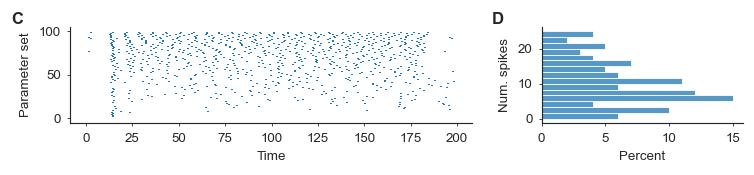

In [36]:
fig, axs = pltu.subplots(2, 1, gridspec_kw=dict(width_ratios=[2, 1]), ysizerow=1.5)
sns.despine()

ax = axs[0]
ax.eventplot(df.acc_events[df.acc_n_spikes.argsort()].apply(lambda x: x[gen.vidx]), color=theta_color);
ax.set(xlabel='Time', ylabel='Parameter set')

ax = axs[1]
sns.histplot(ax=ax, data=df, y="acc_n_spikes", color=theta_color, bins=theta_bins, stat='percent')
ax.set(ylabel='Num. spikes')

pltu.set_labs(panel_nums=['C'], axs=axs[0], panel_num_space=10)
pltu.set_labs(panel_nums=['D'], axs=axs[1], panel_num_space=8)

plt.tight_layout(rect=[0.01, 0, 1, 1 ], w_pad=2)
pltu.savefig("figS4_c_d")
plt.show()

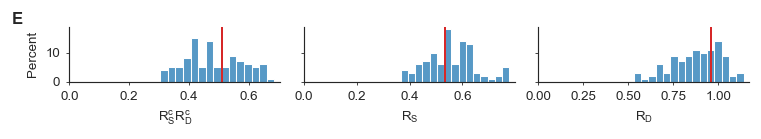

In [37]:
def plot_R_hist(ax, x):
    sns.histplot(ax=ax, data=df, x=x, stat='percent', bins=theta_bins, color=theta_color)
    ax.axvline(df_cal.loc[best_pert_param, x], c=cal_color)
    ax.set(xlabel=pltu.text2mathtext(pltu.metric2label(x)), xlim=(0, None))
    

fig, axs = pltu.subplots(3, 1, sharey=True)
sns.despine()

ax = axs[0]
plot_R_hist(ax=ax, x='MAERP_SM_DR_c')

ax = axs[1]
plot_R_hist(ax=ax, x='MAER_SM_SR')

ax = axs[2]
plot_R_hist(ax=ax, x='MAER_DR_SR')

pltu.set_labs(panel_nums=['E'], axs=axs[0], panel_num_space=10)

plt.tight_layout(rect=[0.01, 0, 1, 1 ])
pltu.savefig("figS4_e")
plt.show()

# Text

In [38]:
gen.n_samples

100

In [39]:
(df.MAERP_SM_DR_c > df_cal.loc[best_pert_param, "MAERP_SM_DR_c"]).sum()

39

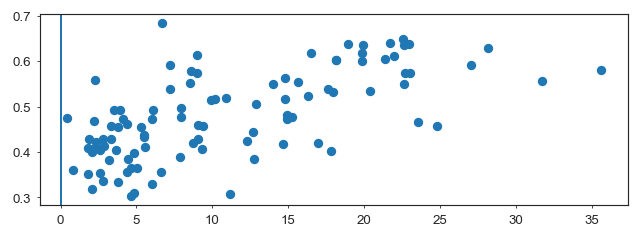

In [40]:
plt.scatter(df.MAE_SR_avg, df.MAERP_SM_DR_c)
plt.axvline()

In [41]:
df[df.MAERP_SM_DR_c <= 0.3].shape

(0, 23)

### Sanity check

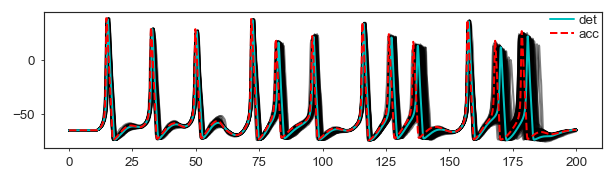

In [42]:
sol, det_sol, acc_sol = eval_params(gK_default, gN_default, gL_default, Iamp_default, verbose=False, plot=True, seed=46*2)

vs = sol.get_ys(yidx=gen.vidx)
det_vs = det_sol.get_ys(yidx=gen.vidx)
acc_vs = acc_sol.get_ys(yidx=gen.vidx)

MAE_SM, MAE_SR, MAE_DR = dl.compute_maes(samples=vs, target=acc_vs, det=det_vs)

In [43]:
df_test = pd.DataFrame({'MAE_SM': np.mean(MAE_SM), 'MAE_SR': np.mean(MAE_SR), 'MAE_DR': MAE_DR, 'n_samples': sol.n_samples}, index=[0])

In [44]:
df_test = utils.add_SR_SM(df_test)

In [45]:
df_test.MAERP_SM_DR_c.iloc[0] / df_cal.loc[best_pert_param, 'MAERP_SM_DR_c']

1.0291990972316873